# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [1]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [2]:
str(date.today())

'2020-09-12'

In [3]:
st.get_links()

<Response [200]>


'wrote 161 links to data_acquisition/links-tsp-2020-09-12.txt'

In [4]:
scraped_file = 'data_acquisition/links-tsp-' + str(date.today()) + '.txt'
st.select_new_links(scraped_file)

got 161 links. 
wrote 1 links to data_acquisition/links-tsp-2020-09-12-new.txt


Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the number that was returned the last time the cell ran.

In [54]:
import os

path_to_link_file= 'data_acquisition/links-tsp-'+str(date.today())+'-new.txt'
path_to_output_folder='data_acquisition/tagesspiegel-'+str(date.today())

_, dirs, _ = next(os.walk('data_acquisition'))
#print(dirs)
if 'tagesspiegel-'+str(date.today()) in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1478,path_to_output_folder)

1573

When articles are downloaded, add new links to 'bestand' (this file is needed to check for already downloaded articles, articles that are scraped on more than one occasion)

In [55]:
!cat $path_to_link_file >> 'data_acquisition/links-tsp-bestand.txt'

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 5. remove content from plus.tagesspiegel.de (advertising, infotainment, Kundenbindung)
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [1]:
from data_cleaning import clean_tsp as ct

In [84]:
ct.clean_up('data_acquisition/tagesspiegel-2020-09-12','2020-09-12')

{'files inspected': 0,
 'files with ads': 44,
 'ads removed': 58,
 'files not clean': 5,
 'files not clean reasons': ['content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'too short'],
 'dates imputed': 0}

In [86]:
# move clean files to where they will be picked up downstream in our workflow
!mv data_acquisition/tagesspiegel-2020-09-12/*clean.json articles_02

In [2]:
ct.impute_description('articles_02')

In [33]:
_, _, file = next(os.walk('articles_02'))
#print(dirs)
#print(file)
for f in file:
    #print(f)
    with open('articles_02/'+f,'r') as ff:
        a1 = ff.read()
        a2 = json.loads(a1)
#        print(a2['text-link'], list(a2.keys()))
        if 'description' not in list(a2.keys()):
            print(f)
  #          a2['description']=a2['title']
   #         print(a2)
    #        a3 = json.dumps(a2, indent=4) # dumps , before used dump
     #       with open('articles_02/'+f,'w') as fff:
      #          fff.write(a3)

### protocols from previous cleanings

In [8]:
ct.clean_up('data_acquisition/tagesspiegel-2020-09-09','2020-09-09')

{'files inspected': 0,
 'files with ads': 63,
 'ads removed': 96,
 'files not clean': 8,
 'files bot clean reasons': ['too short',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)',
  'content from plus.tagesspiegel.de (url)'],
 'dates imputed': 0}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [34]:
from ml_task import non_triv_ml as ml
# my code

ml.preprocess does some basic transfomation of a (German) text into a wordlist:

* Remove non ascii symbols and numbers / digits.
* Remove punctuation. 
* Lemmatize (for German language).

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

In [36]:
X = ml.read_articles_transform_to_df('articles_02/*clean.json',debug=False)
#X['text'][0] # to check what we work with: Umlaute are correct, Data cleaning should have removed advertising text ...

175 files to work with.


In [41]:
# check result of read articles and transform to df:
X.head()

,file,file_name,title,text,description,date,image
0,articles_02/01417-clean.json,01417,Scheel rechnet mit baldiger Entscheidung über ...,Berlins Stadtentwicklungssenator Sebastian Sch...,Seit mehr als einem Jahr steht die Initiative ...,2020-09-11 09:16:28+02:00,https://www.tagesspiegel.de/images/deutsche-wo...
1,articles_02/01420-clean.json,01420,Retourkutsche zum Zwinger,"Barocke Feste, da denkt man zuerst natürlich a...",Deutsches Versailles: Dresden feiert die Fürst...,2019-06-25 09:14:36+02:00,https://www.tagesspiegel.de/images/heprodimage...
2,articles_02/01442-clean.json,01442,Bundeswehr verteilt Rosen am Brandenburger Tor,Die Bundeswehr wirbt zum Internationalen Fraue...,Die deutschen Streitkräfte wollen zum Weltfrau...,2019-03-07 08:09:30+01:00,https://www.tagesspiegel.de/images/fruehlingsw...
3,articles_02/01396-clean.json,01396,Laschet sucht Erfolg als „Merkel 2.0“,Die Kommunalwahlen in Nordrhein-Westfalen steh...,Die Stimmung wendet sich: Laschets Kurs in der...,2020-09-05 19:51:14+02:00,https://www.tagesspiegel.de/images/armin-lasch...
4,articles_02/01469-clean.json,01469,War's schlimm und eng? - Nö!,"Sein Vater ist früh gestorben, er ist früh ges...",Lehrer wollte er werden. Und kam in die DDR. D...,2020-09-11 10:34:35+02:00,https://www.tagesspiegel.de/images/maungue/261...


### compare : cluster titles (short, fast) or cluster text (long, slow)

Is it better to cluster by applying K-means to to titles or to the full text of the article? Since titles are short, clustering them is faster. But is the quality of clustering the full texts higher?

How do the resulting clusters differ?

In [107]:
def my_clustering(list_of_strings, max_df , min_df , n_clusters):

    tfidf = TfidfVectorizer(max_df=max_df , min_df =min_df)
    km =  KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)

    my_pipe = Pipeline([('vect', tfidf), ('cluster', km) ])

    my_pipe.fit(list_of_strings)

    return(tfidf,km)

In [101]:
list_of_titles=[' '.join(ml.preprocess(t)) for t in X['title']]
tfidf_titles , km_titles=my_clustering(list_of_titles, max_df=0.8 , min_df=3, n_clusters=5)
X['cluster']=pd.DataFrame(km_titles.labels_)

In [ ]:
# it could be good to cluster on the basis of title / headline and description.
# there are more words and it is easier to find overlaps.

# another approach would be to use word embeddings, either pretrained.
# Or: train the word embeddings on the articles' text and then use it only for the titles.

Silhouette Coefficient:  0.08074051166047755


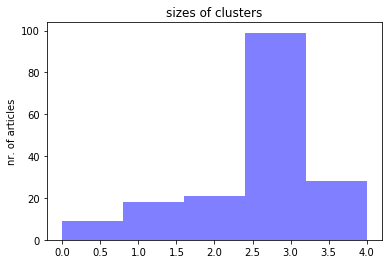

{'n': array([ 9., 18., 21., 99., 28.]),
 'frequencies': [0.051, 0.103, 0.12, 0.566, 0.16],
 'enthropy': 1.2556840180912845,
 'inertia': 130.44505664844732}

In [103]:
V = tfidf_titles.fit_transform(list_of_titles)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_titles.labels_, sample_size=1000))

ml.evaluate_cluster(km_titles)
#cv.get_feature_names()[0:10]

mediocre results:
* small positive silhouette coefficient
* largest cluster comprising around 50%
* smallest cluster comprising around 5%

In [105]:
list_of_texts = [' '.join(ml.preprocess(t)) for t in X['text']]
tfidf_texts, km_texts=my_clustering(list_of_texts, max_df=0.8 , min_df=3, n_clusters=5)
X['cluster']=pd.DataFrame(km_texts.labels_)

Silhouette Coefficient:  0.0117038570015271


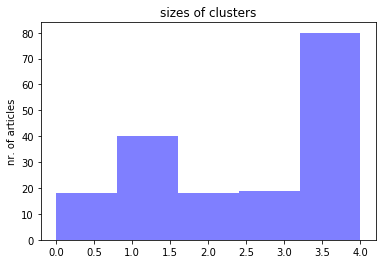

{'n': array([18., 40., 18., 19., 80.]),
 'frequencies': [0.103, 0.229, 0.103, 0.109, 0.457],
 'enthropy': 1.405249295070265,
 'inertia': 152.89770877144858}

In [106]:
V = tfidf_texts.fit_transform(list_of_texts)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_texts.labels_, sample_size=1000))

ml.evaluate_cluster(km_texts)

The clustering wrt the full text at least has a positive silhouette...

### Result: Clustering wrt to titles or full text is not that different when looking at their statistics / scores.

The silouhette coefficient is around zero and inertia high in both cases. Relative differences are not high: Smaller inertia / higher inertia > 90% , difference in silhouette scores / range of scores < 10%

Enthropy is completely independent of our datas dimension, and about the same for both clustering methods: smaller enthropy / larger enthropy > 90%.

### Result: for the newsreader we prefer clustering wrt the full text

since cluster sizes are closer do a uniform distribtion (cluster sizer more evenly distributed).


## HPO: Hyper parameter optimization

In [129]:
from sklearn.model_selection import GridSearchCV
# my pipeline is text_cluster

#parameters: min_df , max_df in vect , n_cluster in cluster

param_grid = dict(vect__min_df=[2,3],
                vect__max_df=[0.7,0.8,0.9],
                 cluster__n_clusters=[5,10,15])

tfidf = TfidfVectorizer()
km =  KMeans()
pipe = Pipeline([('vect', tfidf), ('cluster', km) ])

# Gridsearch arguments: cv=5 for 5-fold cross validation
    # verbose = 2: not so much output, verbose = 0: no messages during search
grid_search=GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=2)
grid_result=grid_search.fit(list_of_texts)
print(grid_result)
print('****')
print(grid_search.best_estimator_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2, total=   2.0s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2, total=   2.2s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2, total=   3.6s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2, total=   2.1s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=2, total=   2.0s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3, total=   1.6s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3, total=   2.1s
[CV] cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3 .........
[CV]  cluster__n_clusters=5, vect__max_df=0.7, vect__min_df=3, total=   2.0s
[CV] cluster__n_clusters=5, vect__m

[CV]  cluster__n_clusters=10, vect__max_df=0.9, vect__min_df=3, total=   1.9s
[CV] cluster__n_clusters=10, vect__max_df=0.9, vect__min_df=3 ........
[CV]  cluster__n_clusters=10, vect__max_df=0.9, vect__min_df=3, total=   1.8s
[CV] cluster__n_clusters=10, vect__max_df=0.9, vect__min_df=3 ........
[CV]  cluster__n_clusters=10, vect__max_df=0.9, vect__min_df=3, total=   2.0s
[CV] cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2 ........
[CV]  cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2, total=   1.8s
[CV] cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2 ........
[CV]  cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2, total=   1.8s
[CV] cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2 ........
[CV]  cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2, total=   1.9s
[CV] cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2 ........
[CV]  cluster__n_clusters=15, vect__max_df=0.7, vect__min_df=2, total=   2.0s
[CV] cluster__n_clusters=15,

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [76]:
# report of grid sech: 
# grid_search.cv_results_

### Best parameters obtained from HPO

In [112]:
# to see the best prameters from HPO:
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
best_parameters['vect'] , best_parameters['cluster']

Best parameters set:


(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=0.9, max_features=None,
                 min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0))

In [114]:
# use them to cluster wrt full texts of articles
list_of_texts=[' '.join(ml.preprocess(t)) for t in X['text']]
tfidf_texts , km_texts=my_clustering(list_of_texts, max_df=0.9 , min_df=3, n_clusters=15)
X['cluster']=pd.DataFrame(km_texts.labels_)

Silhouette Coefficient:  0.04101046848003908


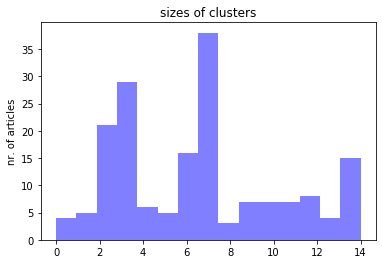

{'n': array([ 4.,  5., 21., 29.,  6.,  5., 16., 38.,  3.,  7.,  7.,  7.,  8.,
         4., 15.]),
 'frequencies': [0.023,
  0.029,
  0.12,
  0.166,
  0.034,
  0.029,
  0.091,
  0.217,
  0.017,
  0.04,
  0.04,
  0.04,
  0.046,
  0.023,
  0.086],
 'enthropy': 2.4041944284809404,
 'inertia': 131.4626918356964}

In [115]:
V = tfidf_texts.fit_transform(list_of_texts)
print('Silhouette Coefficient: ', metrics.silhouette_score(V, km_texts.labels_, sample_size=1000))
ml.evaluate_cluster(km_texts)

In [126]:
# to run the best clustering without looking at the best parameters from HPO
pipe.set_params(**grid_search.best_estimator_.get_params())
pipe.fit(list_of_texts)
#pipe.get_params()
#ml.evaluate_cluster(km)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('cluster',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=15, n_init=10, n_jobs=

In [121]:
pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('cluster',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=15, n_init=10, n_jobs=

In [111]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### how stuff works, the small things ...

In [5]:
# how preprocessing works
preprocess('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')

WordList(['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen'])

In [69]:
# the list of titles
[' '.join(preprocess(t)) for t in X['title']]

['scheel rechnet mit baldig entscheidung über berlin volksbegehren',
 'retourkutschen zum zwinger',
 'Bundeswehr verteilen rosen am brandenburger tor',
 'laschet suchen erfolg als merkel',
 'sein s schlimm und eng nö',
 'wie wir über den erst corona winter kommen entscheidet sich jetzt',
 'der run der wall street auf das vermögen der neu mittelschicht',
 'wieder grossfeuer im hafengebiet von beirut',
 'der aufklärer assange als unperson',
 'lothar corona der fc',
 'horst seehofer der buhmann',
 'bei ein mann werden man sagen wow haben der mumm',
 'die chefin mit neu kollegen',
 'an dies schulen werden neu corona fälle bekannt',
 'die stadt ist wild als du denkst und freundlich als du glaubst',
 'die chinesisch international dienstleistungsmesse wurde erfolgreich abgeschlossen',
 'Warnstreiks bei der post in berlin',
 'trump vergleichen sich mit churchill',
 'patricia schlesinger vor wiederwahl',
 'michael rother für mich sein das kein nostalgi trip']

## Word cloud representation for cluster

Collect all text from a specified cluster and create its wordcloud.

Some stopwords are features.

In [77]:
my_stopper = ['ist','nur','sein','seine','deine','meine','am','sie','bei','durch','noch','sich','in','im','ihr','ihre','vor','zur','seit','es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']
'ist' in my_stopper
# [w in cv.get_feature_names() for w in my_stopper]

True

For each cluster save the articles belonging to the cluster in a csv file.

For each cluster create a wordcloud from all article titles to represent the cluster.


In [79]:
#!pip install wordcloud
from wordcloud import WordCloud

K=km.n_clusters
for k in range(K):
    Xcl = X.loc[X['cluster']==k]
    
    # write articles in this cluster to csv file
    ## needed later to display headlines and text from the (externally running) Flask server
    
    filename = 'html_pres/static/articles_cluster'+str(k)+'.csv'
    Xcl.to_csv(filename, sep=';', encoding='utf-8', header=True)
    
    # all words of all titles in one string, preprocessed and without stopp words
    t1 = [' '.join(ml.preprocess(t)) for t in Xcl['title']]
    t2 = ' '.join(t1)
    text = [w for w in t2.split() if w not in my_stopper]
    
    wordcloud = WordCloud().generate(' '.join(text))
    wordcloud.to_file('html_pres/static/image_cluster'+str(k)+'.png')

## presentation as html , website

* call an external python script to start the server (Flask)
* go to 127.0.0.0:5005 to interact with the website

In [150]:
!python html_pres/app.py $K

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 255-048-271
range(0, 5)
127.0.0.1 - - [13/Sep/2020 22:20:40] "GET / HTTP/1.1" 200 -
^C


In [143]:
K=5
[[k,'image_cluster'+str(k)+'.png'] for k in range(K)]

[(0, 'image_cluster0.png'),
 (1, 'image_cluster1.png'),
 (2, 'image_cluster2.png'),
 (3, 'image_cluster3.png'),
 (4, 'image_cluster4.png')]

In [56]:
# to be deleted
list_of_titles = [' '.join(ml.preprocess(t)) for t in X['title']]

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

title_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_titles[0:100])
title_cluster.fit(list_of_titles)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels